In [25]:
! pip install pyDOE
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import torch.optim as optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

torch.manual_seed(1234)
np.random.seed(1234)


if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1234)

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(device)

True
1
cuda


In [26]:
# Define problem dimensions
x_min = 0.0  # Minimum value for x
x_max = 1.0   # Maximum value for x
y_min = 0.0  # Minimum value for y
y_max = 1.0   # Maximum value for y
N_b = 2000    # Number of boundary points
N_c = 20000    # Number of collocation points

ub = np.array([x_max , y_max])
lb = np.array([x_min , y_min])


T_left = 0
T_right = 0
T_bottom = 0
T_top = 1

def getData():

    left_wall = np.concatenate([
    np.full((N_b // 4, 1), 0),            # x coordinates (-1.0)
    np.random.uniform(0.0, 1.0, (N_b // 4, 1))  # y coordinates
    ], axis=1)

    T_i = np.full((N_b // 4, 1), T_left)

    right_wall = np.concatenate([
    np.full((N_b // 4, 1), 1.0),             # x coordinates (1.0)
    np.random.uniform(0.0, 1.0, (N_b // 4, 1))  # y coordinates
    ], axis=1)

    T_o = np.full((N_b // 4, 1), T_right)

    bottom_wall = np.concatenate([
    np.random.uniform(0.0, 1.0, (N_b // 4, 1)),  # x coordinates
    np.full((N_b // 4, 1), 0.0)                 # y coordinates (-1.0)
    ], axis=1)

    T_bottom_array = np.full((N_b // 4, 1), T_bottom)

    top_wall = np.concatenate([
    np.random.uniform(0.0, 1.0, (N_b // 4, 1)),  # x coordinates
    np.full((N_b // 4, 1), 1.0)                  # y coordinates (1.0)
    ], axis=1)

    T_top_array = np.full((N_b // 4, 1), T_top)

    xy_bnd = np.concatenate([top_wall, bottom_wall,right_wall,left_wall], axis=0)

    Tv_bnd = np.concatenate([T_top_array, T_bottom_array ,T_o, T_i ], axis=0)


    xy_col = lb + (ub - lb) * lhs(2, N_c)
    xy_col = np.concatenate((xy_col, xy_bnd), axis=0)
    xy_bnd = torch.tensor(xy_bnd, dtype=torch.float32).to(device)
    Tv_bnd = torch.tensor(Tv_bnd, dtype=torch.float32).to(device)
    xy_col = torch.tensor(xy_col, dtype=torch.float32).to(device)


    return xy_col, xy_bnd, Tv_bnd

xy_col, xy_bnd, Tv_bnd = getData()

# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# plt.scatter(xy_col[:,0:1], xy_col[:,1:2], marker='o', alpha=0.4 ,color='blue')
# plt.scatter(xy_bnd[:,0:1], xy_bnd[:,1:2], marker='o', alpha=0.4 ,color='red')
# plt.show()

# fig, ax = plt.subplots()
# plt.scatter(xy_bnd[:,0:1], Tv_bnd, marker='o', alpha=0.4 ,color='blue')

In [27]:
def plotLoss(losses_dict, path, info=["B.C.", "P.D.E."]):
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6))
    axes[0].set_yscale("log")
    for i, j in zip(range(2), info):
        axes[i].plot(losses_dict[j.lower()])
        axes[i].set_title(j)
    plt.show()
    fig.savefig(path)

In [28]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [29]:
class layer(nn.Module):

    def __init__(self, n_in, n_out, activation):
        super().__init__()
        self.layer = nn.Linear(n_in, n_out)
        self.activation = activation

    def forward(self, x):
        x = self.layer(x)
        if self.activation:
            x = self.activation(x)
        return x

In [30]:
class DNN(nn.Module):

    def __init__(self, dim_in, dim_out, n_layer, n_node, ub, lb, activation=nn.Tanh()):
        super().__init__()
        self.net = nn.ModuleList()
        self.net.append(layer(dim_in, n_node, activation))
        for _ in range(n_layer):
            self.net.append(layer(n_node, n_node, activation))
        self.net.append(layer(n_node, dim_out, activation=None))
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        self.net.apply(weights_init)

    def forward(self, x):
        x = (x - self.lb) / (self.ub - self.lb)
        out = x
        for layer in self.net:
            out = layer(out)
        return out

In [31]:
class PINN:


    def __init__(self) -> None:
        self.net = DNN(dim_in=2, dim_out=3, n_layer=4, n_node=40, ub=ub, lb=lb).to(
            device
        )




        self.lbfgs = torch.optim.LBFGS(
            self.net.parameters(),
            lr=0.1,
            max_iter=20000,
            max_eval=20000,
            tolerance_grad=1e-5,
            tolerance_change= 1 * np.finfo(float).eps,
            history_size=100,
            line_search_fn="strong_wolfe",
        )

        self.adam = torch.optim.Adam(self.net.parameters(), lr=5e-4)
        self.losses = {"bc": [], "pde": []}
        self.iter = 0

    def predict(self, xy):
        out = self.net(xy)

        T = out[:, 0:1]
        q_x = out[:, 1:2]
        q_y = out[:, 2:3]


        return T, q_x, q_y

    def bc_loss(self, xy):
        T = self.predict(xy)[0]

        mse_bc = torch.mean(torch.square(T - Tv_bnd))

        return mse_bc



    def pde_loss(self, xy):
        xy = xy.clone()
        xy.requires_grad = True

        T, q_x, q_y = self.predict(xy)

        T_out = grad(T.sum(), xy, create_graph=True)[0]
        q_x_out = grad(q_x.sum(), xy, create_graph=True)[0]
        q_y_out = grad(q_y.sum(), xy, create_graph=True)[0]

        T_x = T_out[:, 0:1]
        T_y = T_out[:, 1:2]
        q_x_x = q_x_out[:, 0:1]
        q_y_y = q_y_out[:, 1:2]


        f0 = q_x_x + q_y_y
        f1 = q_x - T_x
        f2 = q_y - T_y


        mse_f0 = torch.mean(torch.square(f0))
        mse_f1 = torch.mean(torch.square(f1))
        mse_f2 = torch.mean(torch.square(f2))


        mse_pde0 = mse_f0
        mse_pde1 = mse_f1
        mse_pde2 = mse_f2

        return mse_pde0 + mse_pde1 + mse_pde2

    def closure(self):

        self.lbfgs.zero_grad()
        self.adam.zero_grad()

        mse_bc = self.bc_loss(xy_bnd) * 10
        mse_pde = self.pde_loss(xy_col)

        loss = mse_bc + mse_pde

        loss.backward()


        self.losses["bc"].append(mse_bc.detach().cpu().item())
        self.losses["pde"].append(mse_pde.detach().cpu().item())

        self.iter += 1

        print(
            f"\r It: {self.iter} Loss: {loss.item():.5e} BC: {mse_bc.item():.3e}  pde: {mse_pde.item():.3e}",
            end="",
        )

        if self.iter % 100 == 0:
            print("")

        return loss


 It: 100 Loss: 9.58576e-01 BC: 9.394e-01  pde: 1.921e-02
 It: 200 Loss: 8.09574e-01 BC: 7.343e-01  pde: 7.525e-02
 It: 300 Loss: 7.19333e-01 BC: 6.241e-01  pde: 9.528e-02
 It: 400 Loss: 5.62122e-01 BC: 4.866e-01  pde: 7.551e-02
 It: 500 Loss: 4.46861e-01 BC: 3.902e-01  pde: 5.670e-02
 It: 600 Loss: 3.57151e-01 BC: 3.220e-01  pde: 3.513e-02
 It: 700 Loss: 3.03492e-01 BC: 2.758e-01  pde: 2.769e-02
 It: 800 Loss: 2.69493e-01 BC: 2.469e-01  pde: 2.263e-02
 It: 900 Loss: 2.44942e-01 BC: 2.252e-01  pde: 1.977e-02
 It: 1000 Loss: 2.32018e-01 BC: 2.115e-01  pde: 2.053e-02
 It: 1100 Loss: 2.23406e-01 BC: 2.023e-01  pde: 2.114e-02
 It: 1200 Loss: 2.16336e-01 BC: 1.952e-01  pde: 2.117e-02
 It: 1300 Loss: 2.09260e-01 BC: 1.886e-01  pde: 2.062e-02
 It: 1400 Loss: 2.03541e-01 BC: 1.830e-01  pde: 2.055e-02
 It: 1500 Loss: 1.95772e-01 BC: 1.760e-01  pde: 1.982e-02
 It: 1600 Loss: 1.90040e-01 BC: 1.704e-01  pde: 1.964e-02
 It: 1700 Loss: 1.84776e-01 BC: 1.652e-01  pde: 1.960e-02
 It: 1800 Loss: 1.79775

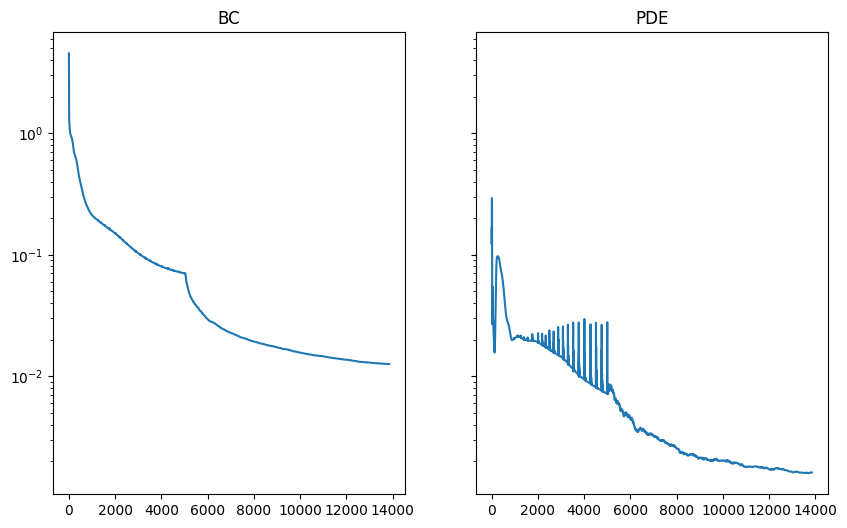

In [32]:
if __name__ == "__main__":

    pinn = PINN()
    start_time = time.time()

    for i in range(5000):
        pinn.closure()
        pinn.adam.step()
    pinn.lbfgs.step(pinn.closure)

    print("--- %s seconds ---" % (time.time() - start_time))
    print(f'-- {(time.time() - start_time)/60} mins --')
    torch.save(pinn.net.state_dict(), "/content/Param.pt")
    plotLoss(pinn.losses, "/content/LossCurve.png", ["BC", "PDE"])


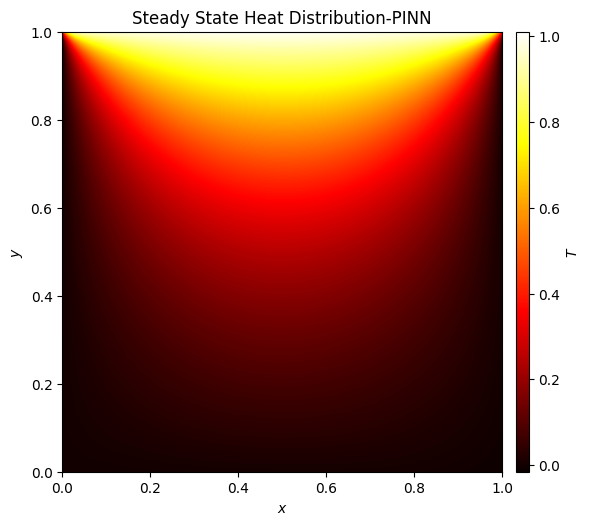

In [33]:
pinn = PINN()

pinn.net.load_state_dict(torch.load("/content/Param.pt"))

x = np.arange(x_min, x_max, 0.001)
y = np.arange(y_min, y_max, 0.001)
X, Y = np.meshgrid(x, y)
x = X.reshape(-1, 1)
y = Y.reshape(-1, 1)
xy = np.concatenate([x, y], axis=1)
xy = torch.tensor(xy, dtype=torch.float32).to(device)
with torch.no_grad():
    T, q_x, q_y = pinn.predict(xy)
    T = T.cpu().numpy()
    T = T.reshape(X.shape)

fig, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
data = T
labels = ["$T$"]
for i in range(1):
    ax = axes
    im = ax.imshow(data, cmap="hot", extent=[x_min, x_max, y_min, y_max], origin="lower")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad="3%")
    fig.colorbar(im, cax=cax, label=labels[i])
    ax.set_title('Steady State Heat Distribution-PINN')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect("equal")
fig.tight_layout()
fig.savefig("/content/Sol.png", dpi=500)
